# Pneumonie-Erkennung auf Röntgenbildern mithilfe eines eigenen CNN-Modells

Dieses Projekt zielt darauf ab, mithilfe von Röntgenaufnahmen der Brust Lungenentzündungen (Pneumonie) automatisch zu erkennen und korrekt zu klassifizieren. Die gesamte Pipeline umfasst die visuelle Analyse und Aufbereitung des Datensatzes, Data Augmentation zur Klassenbalance, den Aufbau eines eigenen Convolutional Neural Networks (CNN), die Trainings- und Validierungsschritte sowie die abschließende Evaluation und eine Live-Demo auf echten Testbildern.

## Importe

In [ ]:
# Standardbibliotheken
import os
import shutil
import random
import numpy as np
from pathlib import Path
import kagglehub

# Bildverarbeitung & Visualisierung
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.lines import Line2D
import seaborn as sns
from PIL import Image

# PyTorch & torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Evaluation & Metriken
from sklearn.metrics import (
    accuracy_score, recall_score, confusion_matrix,
    classification_report, roc_curve, auc,
    precision_recall_curve
)

# Fortschrittsanzeige 
from tqdm import tqdm

## Datensatz von Kaggle herunterladen

In [ ]:
# Datensatz herunterladen
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

# Datensatz vom Cache in das Projektverzeichnis kopieren
src_path = os.path.expanduser("~/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2")
dst_path = "./chest_xray"

if not os.path.exists(dst_path):
    shutil.copytree(src_path, dst_path)
    print("Daten wurden in dein Projektverzeichnis kopiert.")
else:
    print("Zielordner existiert bereits.")

## Visualisierung und Analyse des Datensatzes

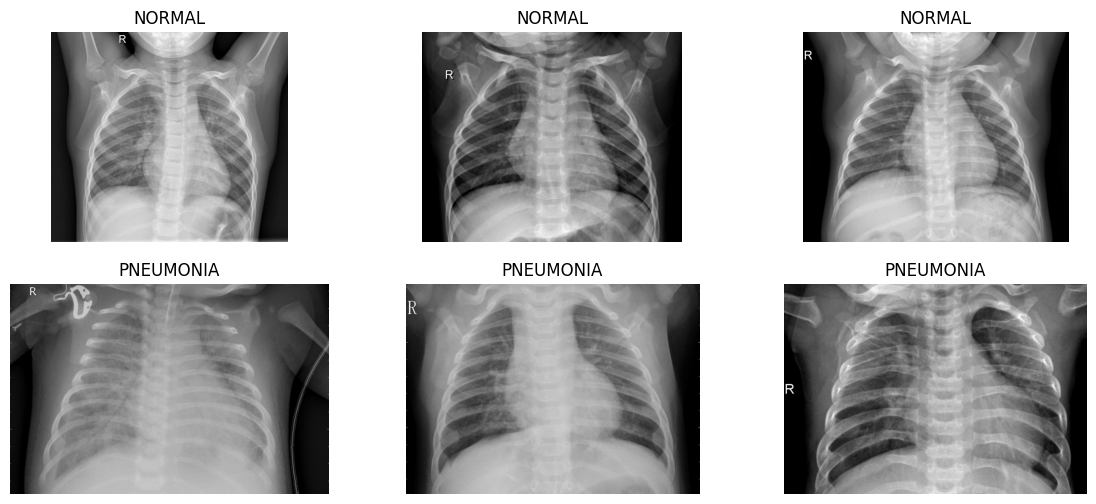

In [ ]:
# Verzeichnisse definieren
base_dir = Path("chest_xray/chest_xray/train")
normal_dir = base_dir / "NORMAL"
pneumonia_dir = base_dir / "PNEUMONIA"

# Beispielbilder laden
normal_images = list(normal_dir.glob("*.jpeg"))[:3]
pneumonia_images = list(pneumonia_dir.glob("*.jpeg"))[:3]

# Beispielbilder plotten
fig, axes = plt.subplots(2, 3, figsize=(14, 6))

# NORMAL-Bilder
for i, img_path in enumerate(normal_images):
    img = mpimg.imread(img_path)
    axes[0, i].imshow(img, cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title("NORMAL", fontsize=12)

# PNEUMONIA-Bilder
for i, img_path in enumerate(pneumonia_images):
    img = mpimg.imread(img_path)
    axes[1, i].imshow(img, cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title("PNEUMONIA", fontsize=12)

plt.show()

📂 Bildanzahl pro Ordner:

TRAIN:
  NORMAL    : 1341
  PNEUMONIA : 3875

TEST:
  NORMAL    : 234
  PNEUMONIA : 390

VAL:
  NORMAL    : 8
  PNEUMONIA : 8



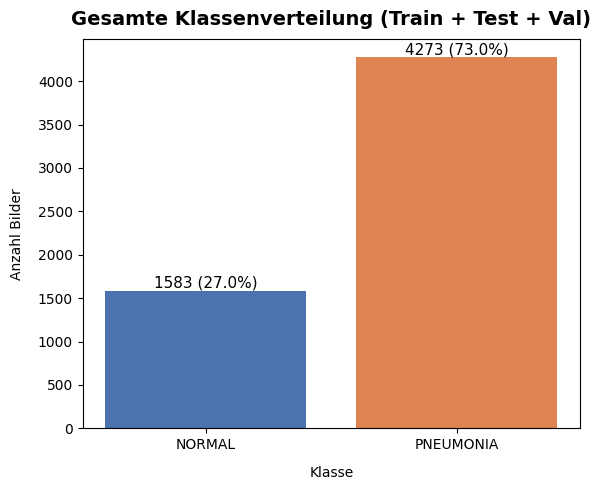

In [ ]:
# Basisordner
data_root = Path("chest_xray/chest_xray")
splits = ["train", "test", "val"]
labels = ["NORMAL", "PNEUMONIA"]

# Dicts zur Speicherung
class_counts = {"NORMAL": 0, "PNEUMONIA": 0}
split_counts = {split: {"NORMAL": 0, "PNEUMONIA": 0} for split in splits}

# Zählen der Bilder
for split in splits:
    for label in labels:
        class_dir = data_root / split / label
        count = len(list(class_dir.glob("*.jpeg")))
        class_counts[label] += count
        split_counts[split][label] = count

# Ausgabe der Bilder pro Split
print("📂 Bildanzahl pro Ordner:\n")
for split in splits:
    print(f"{split.upper()}:")
    for label in labels:
        print(f"  {label:10s}: {split_counts[split][label]}")
    print()

# Plotten der Gesamtverteilung
fig, ax = plt.subplots(figsize=(6, 5))
bars = ax.bar(class_counts.keys(), class_counts.values(), color=["#4c72b0", "#dd8452"])
ax.set_title("Gesamte Klassenverteilung (Train + Test + Val)", fontsize=14, fontweight="bold", pad=10)
ax.set_xlabel("Klasse", labelpad=10)
ax.set_ylabel("Anzahl Bilder", labelpad=10)

# Gesamtanzahl für Prozentberechnung
total_images = sum(class_counts.values())

# Zahlen + Prozent über den Balken anzeigen
for bar, label in zip(bars, class_counts.keys()):
    height = bar.get_height()
    percent = (height / total_images) * 100
    ax.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + 5,
        f'{height} ({percent:.1f}%)',
        ha='center',
        va='bottom',
        fontsize=11
    )

plt.tight_layout()
plt.show()

### Erkenntnisse aus der Datenanalyse

- **Klassenungleichgewicht**:  
  Etwa **73 %** der Bilder zeigen *PNEUMONIA*, nur **27 %** sind *NORMAL*.  
  → Das Modell könnte sonst hauptsächlich Pneumonie vorhersagen und normale Bilder übersehen.


- **Unfaire Datenaufteilung**:  
  Fast alle Bilder sind im Trainingsordner, der Val- und Testsplit ist sehr klein.  
  → Keine gute Basis für eine faire Bewertung des Modells.

**Lösung**:  
Alle Bilder werden **zusammengeführt** und dann **neu aufgeteilt** in:

- 70 % Training  
- 15 % Validierung  
- 15 % Test  

So entsteht ein ausgeglichener und sinnvoller Datensatz für das Modelltraining.


In [ ]:
# Pfade
source_root = Path("chest_xray/chest_xray")
merged_root = Path("chest_xray/merged")
splits = ["train", "test", "val"]
classes = ["NORMAL", "PNEUMONIA"]

# Zielordner erstellen
for cls in classes:
    (merged_root / cls).mkdir(parents=True, exist_ok=True)

# Bilder kopieren (Dateinamen bleiben gleich)
for split in splits:
    for cls in classes:
        src_dir = source_root / split / cls
        dest_dir = merged_root / cls
        for file in src_dir.glob("*.jpeg"):
            target_path = dest_dir / file.name
            if target_path.exists():
                # Wenn gleiche Datei bereits existiert, eindeutig machen
                base, ext = os.path.splitext(file.name)
                counter = 1
                new_name = f"{base}_{split}{ext}"
                while (dest_dir / new_name).exists():
                    new_name = f"{base}_{split}_{counter}{ext}"
                    counter += 1
                shutil.copy(file, dest_dir / new_name)
            else:
                shutil.copy(file, target_path)

print("[INFO] Bilder wurden nach 'chest_xray/merged/' kopiert.")

[INFO] Bilder wurden nach 'chest_xray/merged/' kopiert.


In [ ]:
def dataset_split(merged_dir, output_dir, train_ratio=0.7, val_ratio=0.15, seed=42):
    random.seed(seed)
    classes = ["NORMAL", "PNEUMONIA"]

    # Zielordner erstellen
    for split in ["train", "val", "test"]:
        for cls in classes:
            split_path = Path(output_dir) / split / cls
            split_path.mkdir(parents=True, exist_ok=True)

    # Bilder aufteilen
    for cls in classes:
        class_path = Path(merged_dir) / cls
        images = [f for f in class_path.glob("*.jpeg")]
        random.shuffle(images)

        total = len(images)
        train_end = int(total * train_ratio)
        val_end = train_end + int(total * val_ratio)

        splits = {
            "train": images[:train_end],
            "val": images[train_end:val_end],
            "test": images[val_end:]
        }

        for split, files in splits.items():
            for file in files:
                dest = Path(output_dir) / split / cls / file.name
                shutil.copy(file, dest)

        print(f"[INFO] {cls}: {total} → train={len(splits['train'])}, val={len(splits['val'])}, test={len(splits['test'])}")

dataset_split(
    merged_dir="chest_xray/merged",
    output_dir="chest_xray/dataset",
    train_ratio=0.7,
    val_ratio=0.15,
    seed=42
)

[INFO] NORMAL: 1583 → train=1108, val=237, test=238
[INFO] PNEUMONIA: 4273 → train=2991, val=640, test=642


## Data-Augmentation
Da der Datensatz ein starkes Klassenungleichgewicht aufweist, wir dieser durch Data-Augmentation erweitert. Dabei werden neue, leicht veränderte Versionen bestehender Bilder erzeugt, um das Modell robuster zu machen.

Um die Balance zu verbessern, wurde der kleinere NORMAL-Datensatz um 50 % und der größere PNEUMONIA-Datensatz um 20 % erweitert.

Die Augmentierungen beinhalten:
- zufällige Bildausschnitte und Zooms
- horizontales Spiegeln
- leichte Rotationen
- Helligkeit- und Kontraständerungen
- kleine Verschiebungen und Shearing

In [ ]:
def train_augmentation(train_dir, augment_factor=0.5, seed=42):
    random.seed(seed)
    train_dir = Path(train_dir)
    images = [f for f in train_dir.glob("*.jpeg")]

    num_original = len(images)
    num_to_generate = int(num_original * augment_factor)

    # Transformationspipeline
    transform = transforms.Compose([
        transforms.RandomResizedCrop(size=(224, 224), scale=(0.9, 1.1), ratio=(0.95, 1.05)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=10),
        transforms.ColorJitter(brightness=0.15, contrast=0.15),
        transforms.RandomAffine(
            degrees=0,
            translate=(0.05, 0.05),
            shear=5
        ),
    ])

    # Generierung der augmentierten Bilder
    for i in range(num_to_generate):
        img_path = random.choice(images)
        with Image.open(img_path) as img:
            # Konvertiere ggf. in RGB (einige X-Ray-Bilder sind "L")
            if img.mode != 'RGB':
                img = img.convert('RGB')
            augmented = transform(img)
            new_name = f"aug_{i}_{img_path.name}"
            augmented.save(train_dir / new_name)

# Normale (50%) und Pneumonie-Bilder (20%) augmentieren
train_augmentation("chest_xray/dataset/train/NORMAL", augment_factor=0.5)
train_augmentation("chest_xray/dataset/train/PNEUMONIA", augment_factor=0.2)

## CNN-Modell

Für die Klassifikation der Röntgenbilder wurde ein eigenes **Convolutional Neural Network (CNN)** entworfen. Das Modell besteht aus fünf aufeinanderfolgenden *Convolutional-Blöcken*, gefolgt von einem klassischen *MLP-Kopf* zur binären Entscheidung zwischen **NORMAL** und **PNEUMONIA**.

### Aufbau:

Jeder Block enthält:

- eine `2D-Convolution` (3×3-Kernel, Padding=1)  
- eine `ReLU`-Aktivierung  
- ein `Dropout` zur Regularisierung *(Dropout-Rate: 0.2)*  
- ein `MaxPooling` (2×2), um die Featuremaps zu verkleinern  

Im Klassifizierungsbereich folgt:

- eine `Flatten`-Schicht (aus den Featuremaps)  
- eine vollverbundene Schicht mit `128 Neuronen`  
- erneut `ReLU` und `Dropout`  
- eine finale `Linear-Schicht` mit `1 Output` für die binäre Entscheidung  

Das Modell ist auf **Graustufenbilder (1 Kanal)** mit einer **Bildgröße von 224×224** ausgelegt.


In [ ]:
class PneumoniaClassifier(nn.Module):
    def __init__(self):
        super(PneumoniaClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),   # (1, 224, 224) → (32, 224, 224)
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(2),                              # → (32, 112, 112)

            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # (32, 112, 112) → (64, 112, 112)
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(2),                              # → (64, 56, 56)

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # (64, 56, 56) → (128, 56, 56)
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(2),                              # → (128, 28, 28)

            nn.Conv2d(128, 256, kernel_size=3, padding=1), # (128, 28, 28) → (256, 28, 28)
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(2),                              # → (256, 14, 14)

            nn.Conv2d(256, 512, kernel_size=3, padding=1), # (256, 14, 14) → (512, 14, 14)
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(2)                               # → (512, 7, 7)
        )

        
        self.classifier = nn.Sequential(
            nn.Flatten(),  # → 512*7*7 = 12544
            nn.Linear(512 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1),  # Binäre Klassifikation
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

## Datenvorbereitung & Loss-Funktion
Die Trainings-, Validierungs- und Testdaten werden geladen und mit Standardtransformationen (Grayscale, Resize, Normalize) vorbereitet.  
Außerdem wird das Klassenungleichgewicht berücksichtigt: Pneumonie tritt häufiger vor als normale Befunde.  
Deshalb wird ein **gewichteter Binary Cross Entropy Loss** verwendet:

`BCEWithLogitsLoss` kombiniert intern **Sigmoid** + **Binary Cross Entropy** und dadurch wird im Modell **keine zusätzliche Sigmoid-Funktion** benötigt.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

img_size = 224
batch_size = 32

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Daten laden
data_root = "chest_xray/dataset"

train_data = ImageFolder(root=os.path.join(data_root, "train"), transform=transform)
val_data   = ImageFolder(root=os.path.join(data_root, "val"), transform=transform)
test_data  = ImageFolder(root=os.path.join(data_root, "test"), transform=transform)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(f"Klassen: {train_data.classes}")

Klassen: ['NORMAL', 'PNEUMONIA']


In [4]:
# Anzahl Bilder pro Klasse zählen
num_normal = len([f for f in os.listdir("chest_xray/dataset/train/NORMAL") if f.endswith(('.jpg', '.jpeg', '.png'))])
num_pneumonia = len([f for f in os.listdir("chest_xray/dataset/train/PNEUMONIA") if f.endswith(('.jpg', '.jpeg', '.png'))])

# Gewicht für positive Klasse (PNEUMONIA = 1)
pos_weight = torch.tensor([num_normal / num_pneumonia], dtype=torch.float32).to(device)

# Loss-Funktion (Sigmoid + BCE) 
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

## Training
Das Modell wird mit einer Trainings- und Validierungsroutine trainiert, die `Accuracy`, `Recall` und `Loss` in jeder Epoche trackt.  
Zusätzlich kommt **Early Stopping** zum Einsatz, um Overfitting zu vermeiden.

In [ ]:
def classifier(model, train_loader, val_loader, test_loader, criterion, epochs=20, patience=3):
    model.train()
    train_losses, val_losses = [], []
    train_recalls, val_recalls = [], []
    train_accuracies, val_accuracies = [], []

    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

    best_val_loss = float('inf')
    early_stopping_counter = 0
    os.makedirs("model", exist_ok=True)

    for epoch in range(epochs):
        running_loss = 0.0
        all_train_preds = []
        all_train_labels = []

        model.train()
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

        for imgs, labels in progress_bar:
            imgs, labels = imgs.to(device), labels.float().unsqueeze(1).to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            progress_bar.set_postfix({'train_loss': loss.item()})

            preds = (torch.sigmoid(outputs) > 0.5).int().cpu().numpy()
            all_train_preds.extend(preds)
            all_train_labels.extend(labels.cpu().numpy())

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_acc = accuracy_score(all_train_labels, all_train_preds)
        train_recall = recall_score(all_train_labels, all_train_preds)
        train_accuracies.append(train_acc)
        train_recalls.append(train_recall)

        # Validierung
        model.eval()
        val_loss = 0.0
        all_val_preds = []
        all_val_labels = []

        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.float().unsqueeze(1).to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = (torch.sigmoid(outputs) > 0.5).int().cpu().numpy()
                all_val_preds.extend(preds)
                all_val_labels.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_acc = accuracy_score(all_val_labels, all_val_preds)
        val_recall = recall_score(all_val_labels, all_val_preds)

        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)
        val_recalls.append(val_recall)

        print(f"Epoch {epoch+1}/{epochs}: "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | Train Recall: {train_recall:.4f} || "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f} | Val Recall: {val_recall:.4f}")
        print("-" * 80)

        # Early Stopping 
        if avg_val_loss < best_val_loss - 1e-4:
            best_val_loss = avg_val_loss
            early_stopping_counter = 0
            torch.save(model.state_dict(), "model/best_model.pth")
            print("💾 Bestes Modell gespeichert.")
        else:
            early_stopping_counter += 1
            print(f"⏳ Kein Fortschritt (Counter: {early_stopping_counter}/{patience})")

        if early_stopping_counter >= patience:
            print(f"⏹️ Early stopping bei Epoche {epoch+1}")
            break

    # Testen des Modells
    model.load_state_dict(torch.load("model/best_model.pth"))  # bestes Modell laden
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.float().unsqueeze(1).to(device)
            outputs = model(imgs)
            preds = (torch.sigmoid(outputs) > 0.5).int().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    test_acc = accuracy_score(all_labels, all_preds)
    test_recall = recall_score(all_labels, all_preds)

    print(f"✅ Final Test Accuracy: {test_acc:.4f} | Recall: {test_recall:.4f}")

    return {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies,
        "train_recalls": train_recalls,
        "val_recalls": val_recalls
    }


In [6]:
model = PneumoniaClassifier().to(device)
results = classifier(model, train_loader, val_loader, test_loader, criterion, epochs=20)

Epoch 1/20: Train Loss: 0.2739 | Train Acc: 0.8134 | Train Recall: 0.8306 || Val Loss: 0.1643 | Val Acc: 0.9156 | Val Recall: 0.8969
--------------------------------------------------------------------------------
💾 Bestes Modell gespeichert.


Epoch 2/20: Train Loss: 0.1501 | Train Acc: 0.9107 | Train Recall: 0.9042 || Val Loss: 0.1569 | Val Acc: 0.9304 | Val Recall: 0.9187
--------------------------------------------------------------------------------
💾 Bestes Modell gespeichert.


Epoch 3/20: Train Loss: 0.1407 | Train Acc: 0.9196 | Train Recall: 0.9145 || Val Loss: 0.1331 | Val Acc: 0.9521 | Val Recall: 0.9547
--------------------------------------------------------------------------------
💾 Bestes Modell gespeichert.


Epoch 4/20: Train Loss: 0.1249 | Train Acc: 0.9259 | Train Recall: 0.9231 || Val Loss: 0.1312 | Val Acc: 0.9487 | Val Recall: 0.9453
--------------------------------------------------------------------------------
💾 Bestes Modell gespeichert.


Epoch 5/20: Train Loss: 0.1053 | Train Acc: 0.9402 | Train Recall: 0.9401 || Val Loss: 0.1221 | Val Acc: 0.9590 | Val Recall: 0.9703
--------------------------------------------------------------------------------
💾 Bestes Modell gespeichert.


Epoch 6/20: Train Loss: 0.0977 | Train Acc: 0.9423 | Train Recall: 0.9418 || Val Loss: 0.0985 | Val Acc: 0.9544 | Val Recall: 0.9734
--------------------------------------------------------------------------------
💾 Bestes Modell gespeichert.


Epoch 7/20: Train Loss: 0.0831 | Train Acc: 0.9505 | Train Recall: 0.9510 || Val Loss: 0.0878 | Val Acc: 0.9601 | Val Recall: 0.9641
--------------------------------------------------------------------------------
💾 Bestes Modell gespeichert.


Epoch 8/20: Train Loss: 0.0751 | Train Acc: 0.9554 | Train Recall: 0.9557 || Val Loss: 0.1222 | Val Acc: 0.9555 | Val Recall: 0.9547
--------------------------------------------------------------------------------
⏳ Kein Fortschritt (Counter: 1/3)


Epoch 9/20: Train Loss: 0.0780 | Train Acc: 0.9528 | Train Recall: 0.9535 || Val Loss: 0.0931 | Val Acc: 0.9601 | Val Recall: 0.9656
--------------------------------------------------------------------------------
⏳ Kein Fortschritt (Counter: 2/3)


Epoch 10/20: Train Loss: 0.0755 | Train Acc: 0.9558 | Train Recall: 0.9579 || Val Loss: 0.0883 | Val Acc: 0.9601 | Val Recall: 0.9750
--------------------------------------------------------------------------------
⏳ Kein Fortschritt (Counter: 3/3)
⏹️ Early stopping bei Epoche 10
✅ Final Test Accuracy: 0.9659 | Recall: 0.9735


## Evaluierung

Zur Beurteilung des Modells wurden Accuracy, Loss und Recall während des Trainings gespeichert und visualisiert. Anschließend wurde das Modell auf einem seperaten Testset evaluiert. Dabei wuden die Metriken Accuracy, Recall, Precision und F1-Score sowie die Konfusionsmatrix, ROC- und Precision-Recall-Kurven betrachtet.

### Metriken während des Trainings plotten

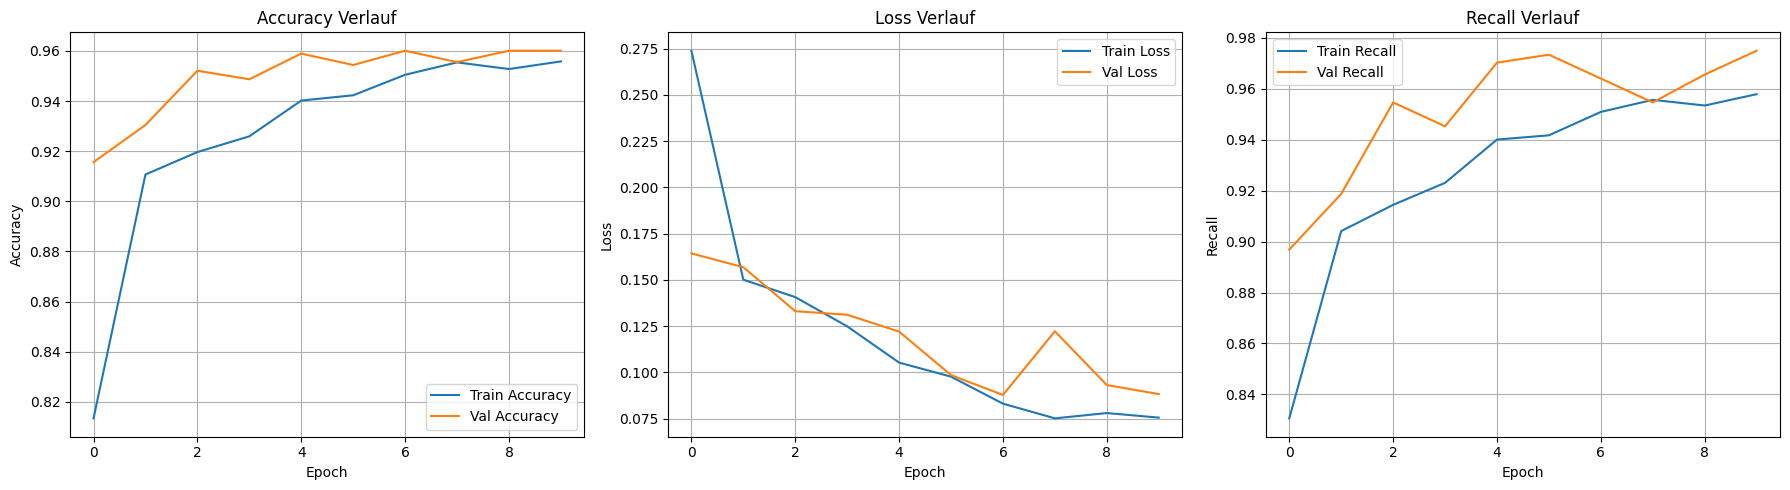

In [ ]:
# Zugriff auf die Ergebnisse
train_losses = results["train_losses"]
val_losses = results["val_losses"]
train_accuracies = results["train_accuracies"]
val_accuracies = results["val_accuracies"]
train_recalls = results["train_recalls"]
val_recalls = results["val_recalls"]

plt.figure(figsize=(18, 5))

# Accuracy
plt.subplot(1, 3, 1)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Val Accuracy")
plt.title("Accuracy Verlauf")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 3, 2)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Verlauf")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Recall
plt.subplot(1, 3, 3)
plt.plot(train_recalls, label="Train Recall")
plt.plot(val_recalls, label="Val Recall")
plt.title("Recall Verlauf")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

- Die **Trainingskurven** zeigen eine stetige Verbesserung, ohne große Schwankungen.
- Die **Validierungskurven** verlaufen stabil und sind sehr nah an den Trainingswerten.
- Es ist **kein Overfitting** erkennbar (gute Generalisierung).
- Besonders der hohe **Recall** ist entscheidend, da falsch-negative Diagnosen bei Pneumonie schwere Folgen haben können.

### Metriken auf dem Testset ausgeben

🧾 Klassifikationsbericht:

              precision    recall  f1-score   support

      NORMAL       0.93      0.95      0.94       238
   PNEUMONIA       0.98      0.97      0.98       642

    accuracy                           0.97       880
   macro avg       0.95      0.96      0.96       880
weighted avg       0.97      0.97      0.97       880



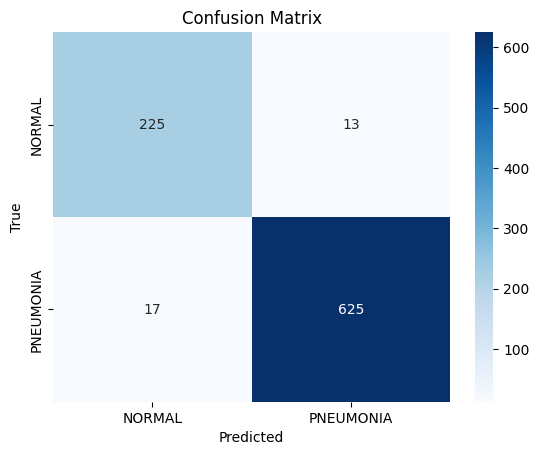

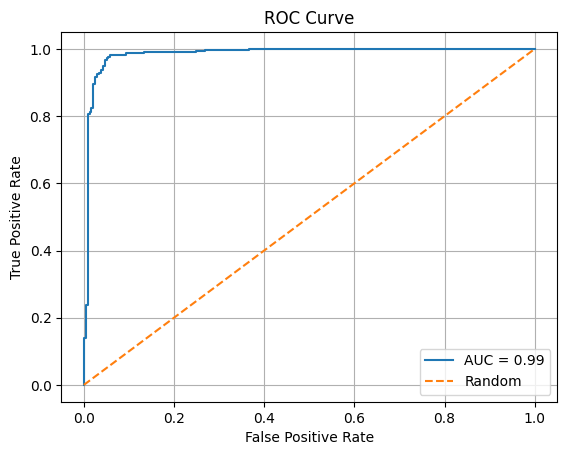

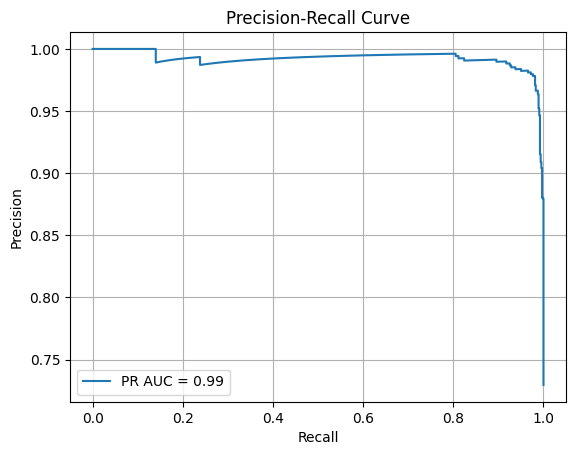

In [ ]:
# Wahre Labels und Scores auf dem Testset
model.load_state_dict(torch.load("model/best_model.pth"))
model.eval()

all_labels = []
all_scores = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        outputs = model(imgs)
        probs = torch.sigmoid(outputs).cpu().numpy().flatten()

        all_scores.extend(probs)
        all_labels.extend(labels.cpu().numpy())

# Binarisierte Vorhersagen mit Schwelle 0.5
y_true = np.array(all_labels)
y_scores = np.array(all_scores)
y_pred = (y_scores > 0.5).astype(int)

# Klassifikationsbericht
print("🧾 Klassifikationsbericht:\n")
print(classification_report(y_true, y_pred, target_names=["NORMAL", "PNEUMONIA"]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["NORMAL", "PNEUMONIA"], yticklabels=["NORMAL", "PNEUMONIA"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='#1F77B4', label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='#FF7F0E', label='Random')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_scores)
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, color='#1F77B4', label=f"PR AUC = {pr_auc:.2f}")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

**Confusion Matrix**

Die Konfusionsmatrix zeigt, dass das Modell sowohl **NORMAL**- als auch **PNEUMONIA**-Fälle sehr gut unterscheidet. Nur wenige Beispiele wurden falsch klassifiziert.

**Roc Curve**

Die ROC-Kurve zeigt die Fähigkeit des Modells, zwischen den Klassen zu unterscheiden. Ein AUC-Wert von **0.99** spricht für eine sehr starke Trennschärfe.

**Precision-Recall Curve**

Auch im Fall eines unausgewogenen Datensatzes bleibt das Modell stark: Die Precision-Recall-Kurve bestätigt die hohe Präzision und Empfindlichkeit (Recall).

## Live-Evaluierung

Zum Abschluss wird das trainierte Modell an zufällig ausgewählten Testbildern getestet.

Dabei wird für jedes Bild vorhergesagt, ob es **NORMAL** oder **PNEUMONIA** ist. Die Vorhersage wird farblich hervorgehoben:

- **Grün** = korrekt klassifiziert
- **Rot** = falsch klassifiziert

So lässt sich visuell nachvollziehen, wie gut das Modell auch bei einzelnen Beispielen funktioniert.

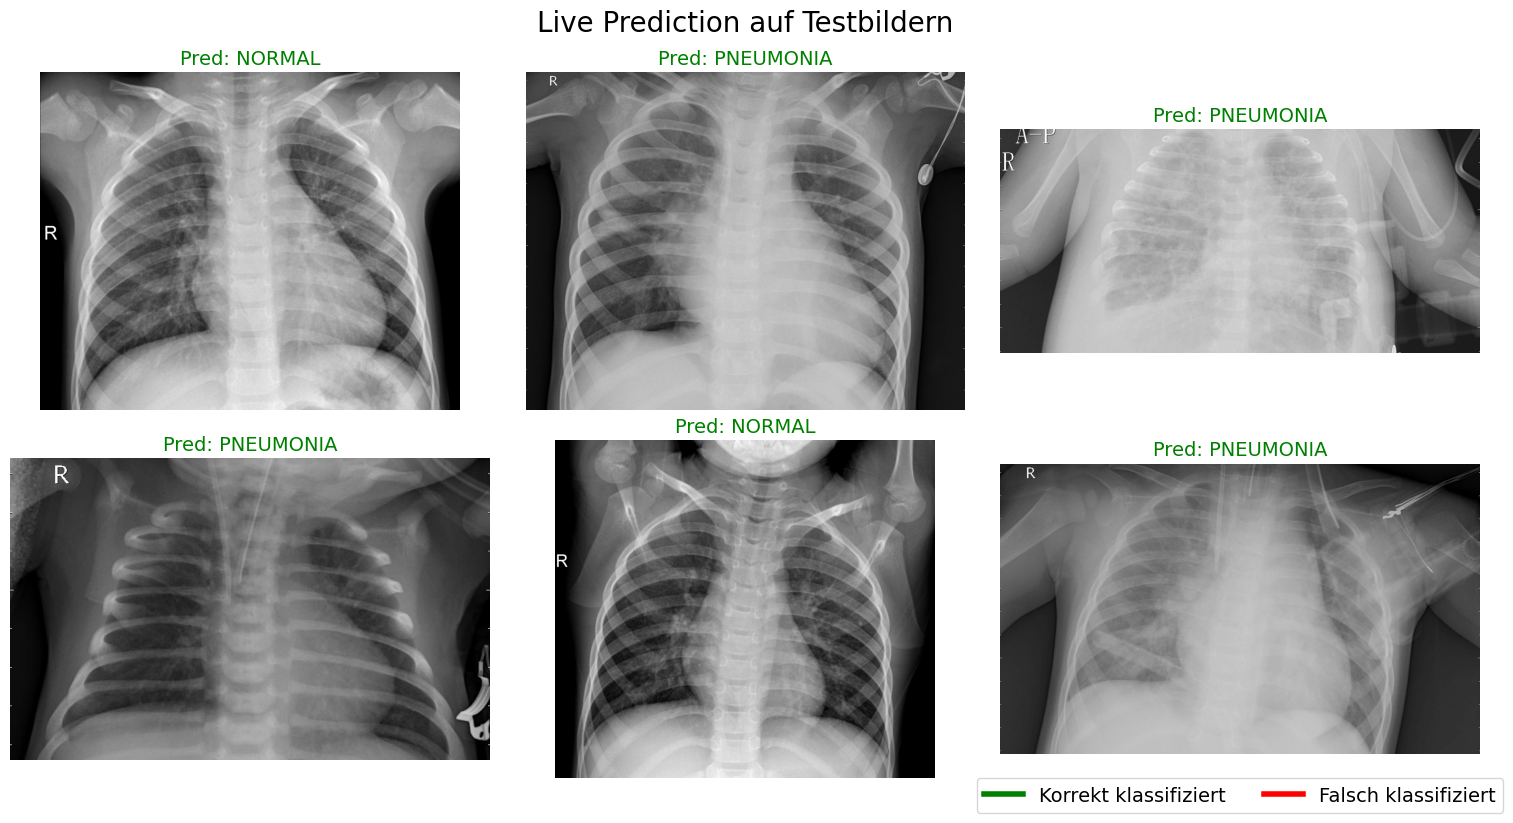

In [ ]:
def show_random_predictions(model, test_data, n=6, device="cpu"):
    # Transformation (wie im Training)
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    # Mapping von Index zu Klassenname
    idx_to_class = {v: k for k, v in test_data.class_to_idx.items()}
    all_test_imgs = [(path, label) for path, label in zip(test_data.imgs, test_data.targets)]

    # Modell vorbereiten
    model.load_state_dict(torch.load("model/best_model.pth"))
    model.eval()

    # Zufällige Stichprobe
    samples = random.sample(all_test_imgs, n)

    # Visualisierung
    cols = 3
    rows = (n + cols - 1) // cols
    plt.figure(figsize=(5 * cols, 4 * rows))

    for i, (img_path, label) in enumerate(samples):
        img = Image.open(img_path[0]).convert("L")
        input_tensor = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_tensor)
            pred = (torch.sigmoid(output) > 0.5).int().item()

        true_label = idx_to_class[label]
        pred_label = idx_to_class[pred]
        correct = pred == label
        color = "green" if correct else "red"

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img, cmap="gray")
        plt.title(f"Pred: {pred_label}", color=color, fontsize=14)
        plt.axis("off")

    plt.suptitle("Live Prediction auf Testbildern", fontsize=20)
    plt.tight_layout()

    # Legende
    legend_elements = [
        Line2D([0], [0], color="green", lw=4, label="Korrekt klassifiziert"),
        Line2D([0], [0], color="red", lw=4, label="Falsch klassifiziert")
    ]
    plt.legend(handles=legend_elements, loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=2, fontsize=14)
    plt.show()

show_random_predictions(model, test_data, n=6, device=device)